In [352]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

'''
This is a notebook that works with the supplemental data provided.
It contains some initial explorations and parts of these code are embedded
within the ExtendedGraphReader notebook as functions.
'''

# Working with the Contacts data (input)

This is the data that is provided as input to the simulation as the basis of contacts happening. 

`contacts.csv` which looks like:

```
    time,from,to,weight,label
    0,14298,14357,100,Restaurant
    0,425,6831,100,School
    0,301,15510,100,ConstructionSite
```

with the following location labels:

```
    array(['Restaurant', 'School', 'ConstructionSite', 'Shop',
           'LargeManyAdultFamily', 'Office', 'CovidHospital', 'LargeAdult',
           'AdultPensioner', 'SmallAdult', 'SmallFamily', 'Hospital',
           'LargeTwoAdultFamily', 'Nursery', 'DoubleOlder', 'CareHome',
           'SingleParent', 'SingleAdult', 'SingleOlder'], dtype=object)
```

In [3]:
inputContacts = pd.read_csv('../../data/2020_07_01_newSet/contacts_covid_model.csv')
inputContacts.head()

,time,from,to,weight,label
0,0,14298,14357,100,Restaurant
1,0,425,6831,100,School
2,0,301,15510,100,ConstructionSite
3,0,1779,18245,100,Shop
4,0,9585,18081,100,School


In [7]:
# These are all the different locations
pd.unique(inputContacts.label)

array(['Restaurant', 'School', 'ConstructionSite', 'Shop',
       'LargeManyAdultFamily', 'Office', 'CovidHospital', 'LargeAdult',
       'AdultPensioner', 'SmallAdult', 'SmallFamily', 'Hospital',
       'LargeTwoAdultFamily', 'Nursery', 'DoubleOlder', 'CareHome',
       'SingleParent', 'SingleAdult', 'SingleOlder'], dtype=object)

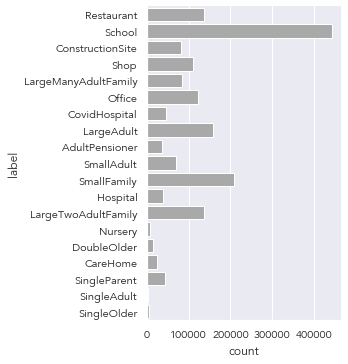

In [246]:
#alt.Chart(inputContacts).mark_bar().encode(
#    alt.X("label", bin=True),
#    y='count()',
#)
sns.catplot(y="label", kind="count", data=inputContacts, color="#A9A9A9");

In [18]:
# Maybe think about what can be done about the time element here
inputContacts['time'].max()

89

In [277]:

# developing a function to return infection location

def returnContactLocation(sourceNode, targetNode, timeOfInfection):
    locationLabel = ""
    isMatch = (inputContacts['from'] == sourceNode) & (inputContacts['to'] == targetNode) & (inputContacts['time'] == timeOfInfection)
    if isMatch.any():
        locationLabel = str(inputContacts[isMatch]['label'].values[0])
    else:
        print("Contact not found at this given time")
    return locationLabel

#Testing the function
sourceNode = 9585
targetNode = 18081
timeOfInfection = 7
returnContactLocation(sourceNode, targetNode, timeOfInfection)


'School'

## Exploring the events data

`events.csv` which looks like this:

```
    time","eventType","id","newStatus","additionalInfo"
    0,"InfectionEvent",2048,"EXPOSED","This case was an initial infection"
    0,"InfectionEvent",4101,"EXPOSED","This case was an initial infection"
```

where there are three different types of `events` : InfectionEvent,  VirusEvent, AlertEvent

and the status changes follow the `compartment` structure that the underlying model follows. Here are the states, I guess these are what an epidemiologist will call compartments:
```
    array(['EXPOSED', 'ASYMPTOMATIC', 'PRESYMPTOMATIC', 'RECOVERED',
           'SYMPTOMATIC', 'REQUESTED_TEST', 'SEVERELY_SYMPTOMATIC',
           'AWAITING_RESULT', 'ALERTED', 'TESTED_POSITIVE', 'TESTED_NEGATIVE',
           'NONE', 'DEAD'], dtype=object)
```

Note: Correction — some of these are compartments but some of them are about events, such as testing, etc.

In [27]:
eventsDF = pd.read_csv('../../data/2020_07_01_newSet/events.csv')
eventsDF.head()

,time,eventType,id,newStatus,additionalInfo
0,0,InfectionEvent,2048,EXPOSED,This case was an initial infection
1,0,InfectionEvent,4101,EXPOSED,This case was an initial infection
2,0,InfectionEvent,4104,EXPOSED,This case was an initial infection
3,0,InfectionEvent,2059,EXPOSED,This case was an initial infection
4,0,InfectionEvent,13,EXPOSED,This case was an initial infection


In [32]:
# These are the different types of events
pd.unique(eventsDF.eventType)

array(['InfectionEvent', 'VirusEvent', 'AlertEvent'], dtype=object)

In [239]:
sns.plotting_context()

{'font.size': 12.0,
 'axes.labelsize': 12.0,
 'axes.titlesize': 12.0,
 'xtick.labelsize': 11.0,
 'ytick.labelsize': 11.0,
 'legend.fontsize': 11.0,
 'axes.linewidth': 1.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

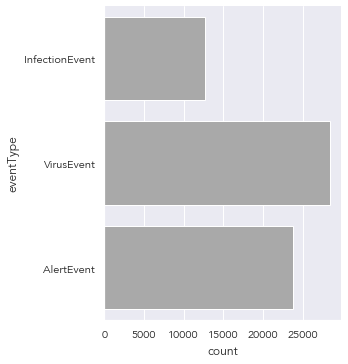

In [243]:
sns.set_style("whitegrid")
sns.set(font="Avenir")
sns.catplot(y="eventType", kind="count", data=eventsDF, color="#A9A9A9");

In [237]:
pd.unique(eventsDF.newStatus)

array(['EXPOSED', 'ASYMPTOMATIC', 'PRESYMPTOMATIC', 'RECOVERED',
       'SYMPTOMATIC', 'REQUESTED_TEST', 'SEVERELY_SYMPTOMATIC',
       'AWAITING_RESULT', 'ALERTED', 'TESTED_POSITIVE', 'TESTED_NEGATIVE',
       'NONE', 'DEAD'], dtype=object)

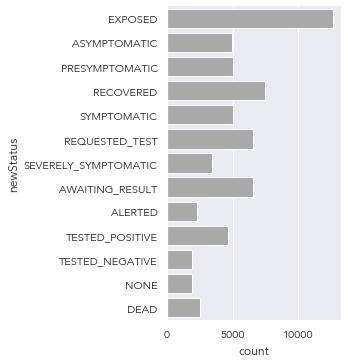

In [245]:
sns.catplot(y="newStatus", kind="count", data=eventsDF, color="#A9A9A9");

In [54]:
groupedByID = eventsDF.groupby(['id'])

In [71]:
#informationSeries = eventsDF.groupby(['id'])['additionalInfo'].apply(list)
# stateChangesPerNode = eventsDF.groupby(['id'])['newStatus'].apply(list)

# The following joins all the string data as separate lists per node
# These could come in handy if we want to do some examples of individual journey visualisations
#statesPerNode = eventsDF.groupby(['id'])['newStatus'].apply(list)
statesPerNode = groupedByID['newStatus'].apply(list)
timeSeriesPerNode = groupedByID['time'].apply(list)
eventTypesPerNode = groupedByID['eventType'].apply(list)

In [278]:
# Check the number of asymptomatic cases
asymptomatic = statesPerNode.apply(lambda x: "ASYMPTOMATIC" in x)
asymptomatic.values.sum() 

4966

In [172]:
statesPerNode[2]

['EXPOSED', 'EXPOSED', 'ASYMPTOMATIC', 'RECOVERED']

In [286]:
timeSeriesPerNode

id
0                    [3, 6, 8, 9, 9, 10, 10, 17]
1                [8, 10, 13, 14, 16, 17, 18, 18]
2                                 [9, 9, 11, 14]
3             [8, 9, 11, 12, 12, 13, 14, 15, 15]
4       [15, 16, 23, 26, 27, 27, 28, 29, 30, 30]
                          ...                   
9995                [13, 21, 22, 23, 24, 24, 27]
9996              [4, 8, 10, 11, 12, 12, 16, 23]
9997                                [10, 11, 12]
9998                                  [2, 4, 12]
9999            [12, 17, 19, 20, 22, 23, 23, 26]
Name: time, Length: 9998, dtype: object

In [287]:
timeSeriesPerNode[0]

[3, 6, 8, 9, 9, 10, 10, 17]

In [79]:
eventTypesPerNode[0]

['InfectionEvent',
 'VirusEvent',
 'VirusEvent',
 'AlertEvent',
 'VirusEvent',
 'AlertEvent',
 'AlertEvent',
 'VirusEvent']

### A second version where we look at only the virus events

In [101]:
groupedByIDAndEventType = eventsDF.groupby(['id', 'eventType'])

In [152]:
statesPerNodeEventType = groupedByIDAndEventType['newStatus'].apply(list)


id    eventType     
0     AlertEvent        [REQUESTED_TEST, AWAITING_RESULT, TESTED_POSIT...
      InfectionEvent                                            [EXPOSED]
      VirusEvent        [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
1     AlertEvent        [REQUESTED_TEST, AWAITING_RESULT, TESTED_NEGAT...
      InfectionEvent                                            [EXPOSED]
                                              ...                        
9998  InfectionEvent                                            [EXPOSED]
      VirusEvent                                [ASYMPTOMATIC, RECOVERED]
9999  AlertEvent        [REQUESTED_TEST, AWAITING_RESULT, TESTED_POSIT...
      InfectionEvent                                            [EXPOSED]
      VirusEvent        [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
Name: newStatus, Length: 26528, dtype: object

In [104]:
timePerNodeEventType = groupedByIDAndEventType['time'].apply(list)

In [105]:
timesPerNodeEventType[86]['VirusEvent']

[3, 10, 15]

# Working on a subset with Virus Events and find transition trails

*This is pretty much the code as above but we start with a suubset of VirusEvents. This is to ensure that we are looking only at events that involve state changes within the compartmentalised model.*

In [166]:
eventsDF.head()
virusEventsDF = eventsDF[eventsDF['eventType'] == 'VirusEvent'] 
virusEventsDF
pd.unique(virusEventsDF.id).size

9998

In [167]:
groupedByID_vir = virusEventsDF.groupby(['id'])

In [168]:
statesPerNode_vir = groupedByID_vir['newStatus'].apply(list)
timeSeriesPerNode_vir = groupedByID_vir['time'].apply(list)
eventTypesPerNode_vir = groupedByID_vir['eventType'].apply(list)

In [174]:
asymptomatic = statesPerNode_vir.apply(lambda x: "ASYMPTOMATIC" in x)

In [170]:
timeSeriesPerNode_vir[asymptomatic.values]

id
2       [11, 14]
5       [14, 16]
6       [18, 19]
7       [12, 17]
9       [15, 16]
          ...   
9990    [20, 26]
9991     [2, 10]
9993    [14, 19]
9997    [11, 12]
9998     [4, 12]
Name: time, Length: 4966, dtype: object

In [175]:
#statesPerNode_vir.to_csv("stateTransitions.csv")
symptomaticIDS = statesPerNode_vir.apply(lambda x: "SYMPTOMATIC" in x)

In [176]:
timeSeriesPerNode_vir[symptomaticIDS.values]

id
0          [6, 8, 9, 17]
1           [10, 13, 16]
3        [9, 11, 12, 13]
4       [23, 26, 27, 28]
8       [11, 16, 19, 24]
              ...       
9992      [8, 9, 10, 16]
9994      [5, 6, 10, 13]
9995        [21, 22, 27]
9996     [8, 10, 16, 23]
9999    [17, 19, 22, 26]
Name: time, Length: 5032, dtype: object

In [177]:
statesPerNode_vir[symptomaticIDS.values]

id
0       [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
1                [PRESYMPTOMATIC, SYMPTOMATIC, RECOVERED]
3       [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
4       [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
8       [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
                              ...                        
9992    [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
9994    [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
9995             [PRESYMPTOMATIC, SYMPTOMATIC, RECOVERED]
9996    [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
9999    [PRESYMPTOMATIC, SYMPTOMATIC, SEVERELY_SYMPTOM...
Name: newStatus, Length: 5032, dtype: object

**Building functionality:** Let's do a function here that checks the status of a node `X` at a given time `t`

In [347]:
#statesPerNode_vir = groupedByID_vir['newStatus'].apply(list)
#timeSeriesPerNode_vir = groupedByID_vir['time'].apply(list)
#eventTypesPerNode_vir = groupedByID_vir['eventType'].apply(list)


def returnDiseaseStatusForNodeAtGivenTime(nodeID, queryTime):
    """Returns the disease status for a node `nodeID` at a given time"""
    statusOfSource = "EXPOSED"
    if queryTime < timeSeriesPerNode_vir[nodeID][0]:
        # This probably shouldn't happen -- someone who is exposed infecting before becoming presymptomatic
        print("An exposed individual infecting others before becoming presymptomatic!!")
    else:    
        timeIndex = np.searchsorted(timeSeriesPerNode_vir[nodeID], queryTime, side = 'right')
        print(timeIndex)
        statusOfSource = statesPerNode_vir[nodeID][timeIndex - 1]
    return statusOfSource

# let's test the above
nodeID = 4
infectionTime = 27
print(statesPerNode_vir[nodeID])
print(timeSeriesPerNode_vir[nodeID]) 
returnDiseaseStatusForNodeAtGivenTime(nodeID, infectionTime)

['PRESYMPTOMATIC', 'SYMPTOMATIC', 'SEVERELY_SYMPTOMATIC', 'RECOVERED']
[23, 26, 27, 28]
3


'SEVERELY_SYMPTOMATIC'

## Reading in the ages for the nodes

In [359]:
nodeAges = pd.read_csv('../../data/2020_07_01_newSet/ids_Paul.csv')
nodeAges['age']


0         1
1         5
2        17
3        29
4        68
         ..
19995    83
19996    33
19997    38
19998    67
19999     0
Name: age, Length: 20000, dtype: int64

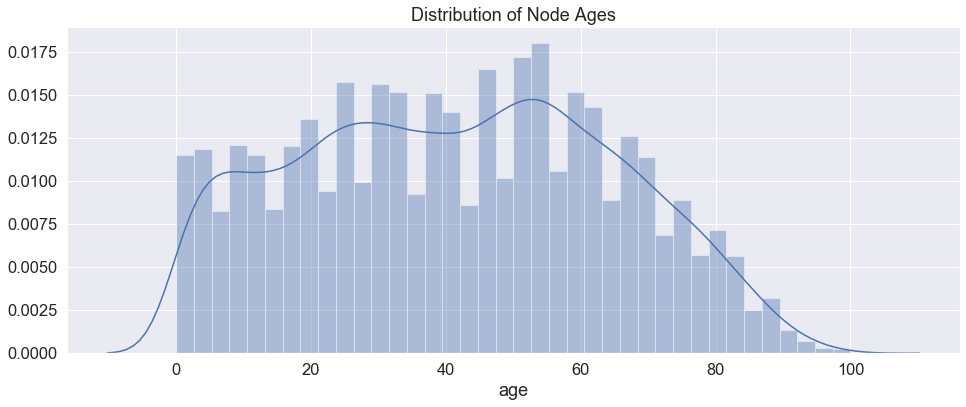

In [354]:
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 6))
sns.distplot(nodeAges['age']).set_title("Distribution of Node Ages");

# Some work with the compartments data

In [178]:
compartments = pd.read_csv('../../data/2020_07_01_newSet/Compartments.csv')
compartments.head()

,time,s,e,a,p,sym,sev,r,d
0,0,9000,1000,0,0,0,0,0,0
1,1,8553,1196,132,119,0,0,0,0
2,2,8134,1304,253,238,35,0,36,0
3,3,7580,1557,358,326,85,1,93,0
4,4,6929,1801,483,449,145,12,181,0


In [226]:
c_melted = compartments.melt('time')
pd.set_option('display.max_rows', 10)

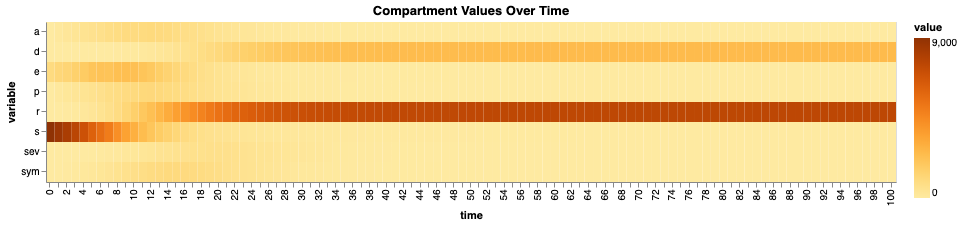

In [228]:
alt.Chart(
    c_melted,
    title="Compartment Values Over Time"
).mark_rect().encode(
    x='time:O',
    y='variable:N',
    color=alt.Color('value:Q', scale=alt.Scale( scheme='yelloworangebrown'))
).properties(width=850)

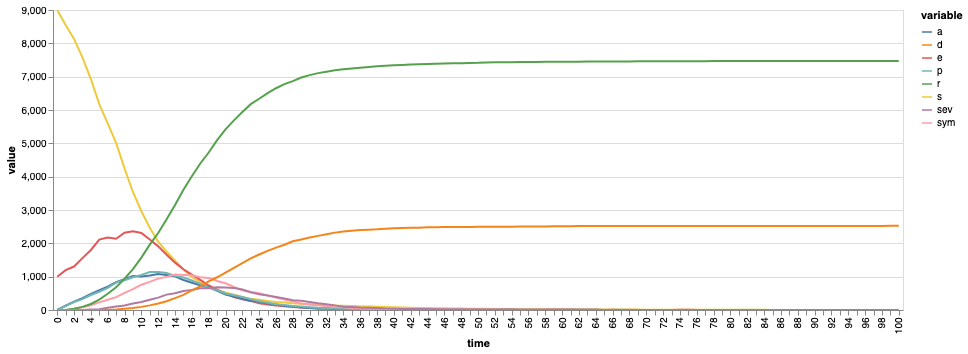

In [231]:
alt.Chart(c_melted).mark_line().encode(
    x='time:O',
    y='value:Q',
    color='variable',
).properties(width=850)

In [222]:
c_m_2 = compartments[['time','a', 'p', 'sym', 'sev']].melt('time')

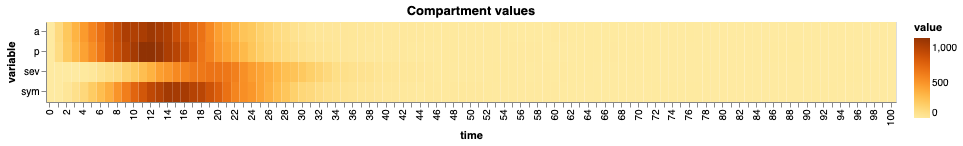

In [224]:
alt.Chart(
    c_m_2,
    title="Compartment Values Over Time (subset)"
).mark_rect().encode(
    x='time:O',
    y='variable:N',
    color=alt.Color('value:Q', scale=alt.Scale(scheme='yelloworangebrown'))
).properties(width=850)